In [1]:
import copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import HTML

from collab2.foraging.toolkit import (
    animate_predictors,
    dataObject,
    generate_local_windows,
    plot_predictor,
    rescale_to_grid,
    subsample_frames_constant_frame_rate,
)
from collab2.foraging.toolkit.decay import _decaying_contribution, _exponential_decay
from collab2.foraging.toolkit.trace import (
    _generate_food_predictor,
    generate_food_predictor,
)

In [2]:
# create a test object with random data
num_frames = 8
num_foragers = 4
grid_size = 30
n_nans = int(num_frames * num_foragers / 5)
n_missing = int(num_frames * num_foragers / 5)
gridMin = -1
gridMax = 1

np.random.seed(42)

theta = 2 * np.pi * np.random.rand(num_frames * num_foragers)
r = np.random.rand(num_frames * num_foragers)

data = {
    "x": r * np.cos(theta),
    "y": r * np.sin(theta),
    "time": np.tile(np.arange(num_frames), num_foragers),
    "forager": np.concatenate([i * np.ones(num_frames) for i in range(num_foragers)]),
}

foragersDF = pd.DataFrame(data)

foragersDF_scaled = rescale_to_grid(
    foragersDF, size=grid_size, gridMin=gridMin, gridMax=gridMax
)
foragers_object = dataObject(foragersDF_scaled, grid_size=grid_size, frames=num_frames)

In [3]:
# get local windows
local_windows_kwargs = {
    "window_size": 10,
    "sampling_fraction": 1,
    "skip_incomplete_frames": False,
}

foragers_object.local_windows_kwargs = local_windows_kwargs

local_windows = generate_local_windows(foragers_object)

In [4]:
test_pred = [[None for i in range(num_frames)] for j in range(num_foragers)]
f = 3
t = 3
x = foragers_object.foragers[f].loc[t, "x"]
y = foragers_object.foragers[f].loc[t, "y"]

In [5]:
trace_1 = _decaying_contribution(
    x_source=16,
    y_source=16,
    grid=local_windows[f][t],
    decay_function=_exponential_decay,
    decay_factor=0.5,
)

trace_2 = _decaying_contribution(
    x_source=9,
    y_source=8,
    grid=local_windows[f][t],
    decay_function=_exponential_decay,
    decay_factor=0.2,
)

# additive combination
test_pred[f][t] = local_windows[f][t].copy()
test_pred[f][t]["trace"] = trace_1 + trace_2

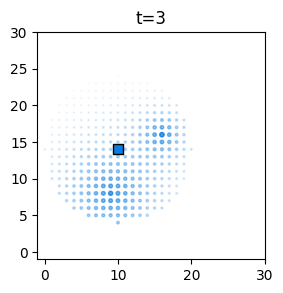

In [6]:
plot_predictor(
    foragers_object.foragers,
    test_pred,
    "trace",
    [f],
    [t],
    grid_size,
    size_multiplier=10,
    random_state=10,
)

In [7]:
# load data
fish_data = pd.read_csv("4wpf_test.csv")
gridMin = 0
gridMax = 300
grid_size = 50
fps = 121

# scaling and subsampling
fishDF_scaled = rescale_to_grid(
    fish_data, size=grid_size, gridMin=gridMin, gridMax=gridMax
)
fishDF_scaled_subsampled = subsample_frames_constant_frame_rate(
    fishDF_scaled, frame_spacing=60, fps=fps
)

# create a test foragers object with 20 frames
num_frames = 20
foragers_object = dataObject(
    fishDF_scaled_subsampled.loc[fishDF_scaled_subsampled["time"] < 20],
    grid_size=grid_size,
)

# get local windows
local_windows_kwargs = {
    "window_size": grid_size / 2,
    "sampling_fraction": 1,
    "skip_incomplete_frames": True,
}

foragers_object.local_windows_kwargs = local_windows_kwargs

local_windows = generate_local_windows(foragers_object)

original_frames: 18739
original_shape: (74956, 5)
resulting_frames: 313
resulting_shape: (1252, 5)
new frame-rate =  2.02


/home/rafal/s78projects/collaborative-intelligence/collab2/foraging/toolkit/utils.py:36: UserWarning:  Nan values in data.
                Specify handling of missing data using `skip_incomplete_frames` argument to `generate_all_predictors`
  warnings.warn(


In [8]:
# fake rewards

rewards = copy.deepcopy(foragers_object.foragers[:2])

for r in rewards:
    r.drop(columns="theta", inplace=True)
    r.rename(columns={"forager": "reward"}, inplace=True)

rewards[0]["x"] = 16
rewards[0]["y"] = 16

rewards[1]["x"] = 13
rewards[1]["y"] = 10

In [9]:
ppr = _generate_food_predictor(
    rewards=rewards,
    foragers=foragers_object.foragers,
    local_windows=local_windows,
    predictor_name="pred",
    decay_function=_exponential_decay,
    decay_factor=0.5,
)

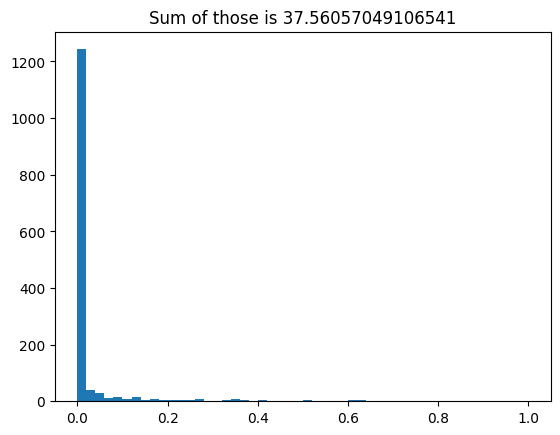

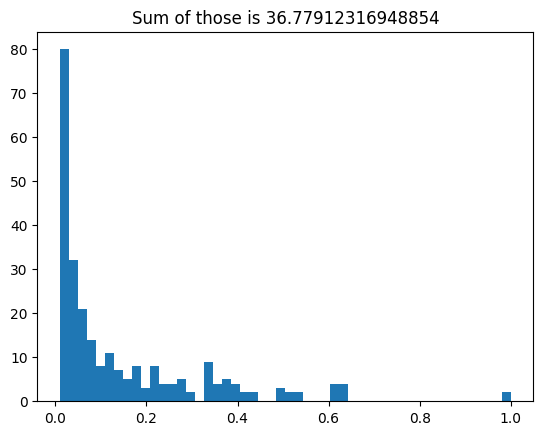

In [10]:
ppr_non_null = ppr[0][0]["pred"][ppr[0][0]["pred"] > 0.01]

plt.hist(ppr[0][0]["pred"], bins=50)
plt.title(f"Sum of those is {ppr[0][0]['pred'].abs().sum()}")
plt.show()

plt.hist(ppr_non_null, bins=50)
plt.title(f"Sum of those is {ppr_non_null.abs().sum()}")
plt.show()

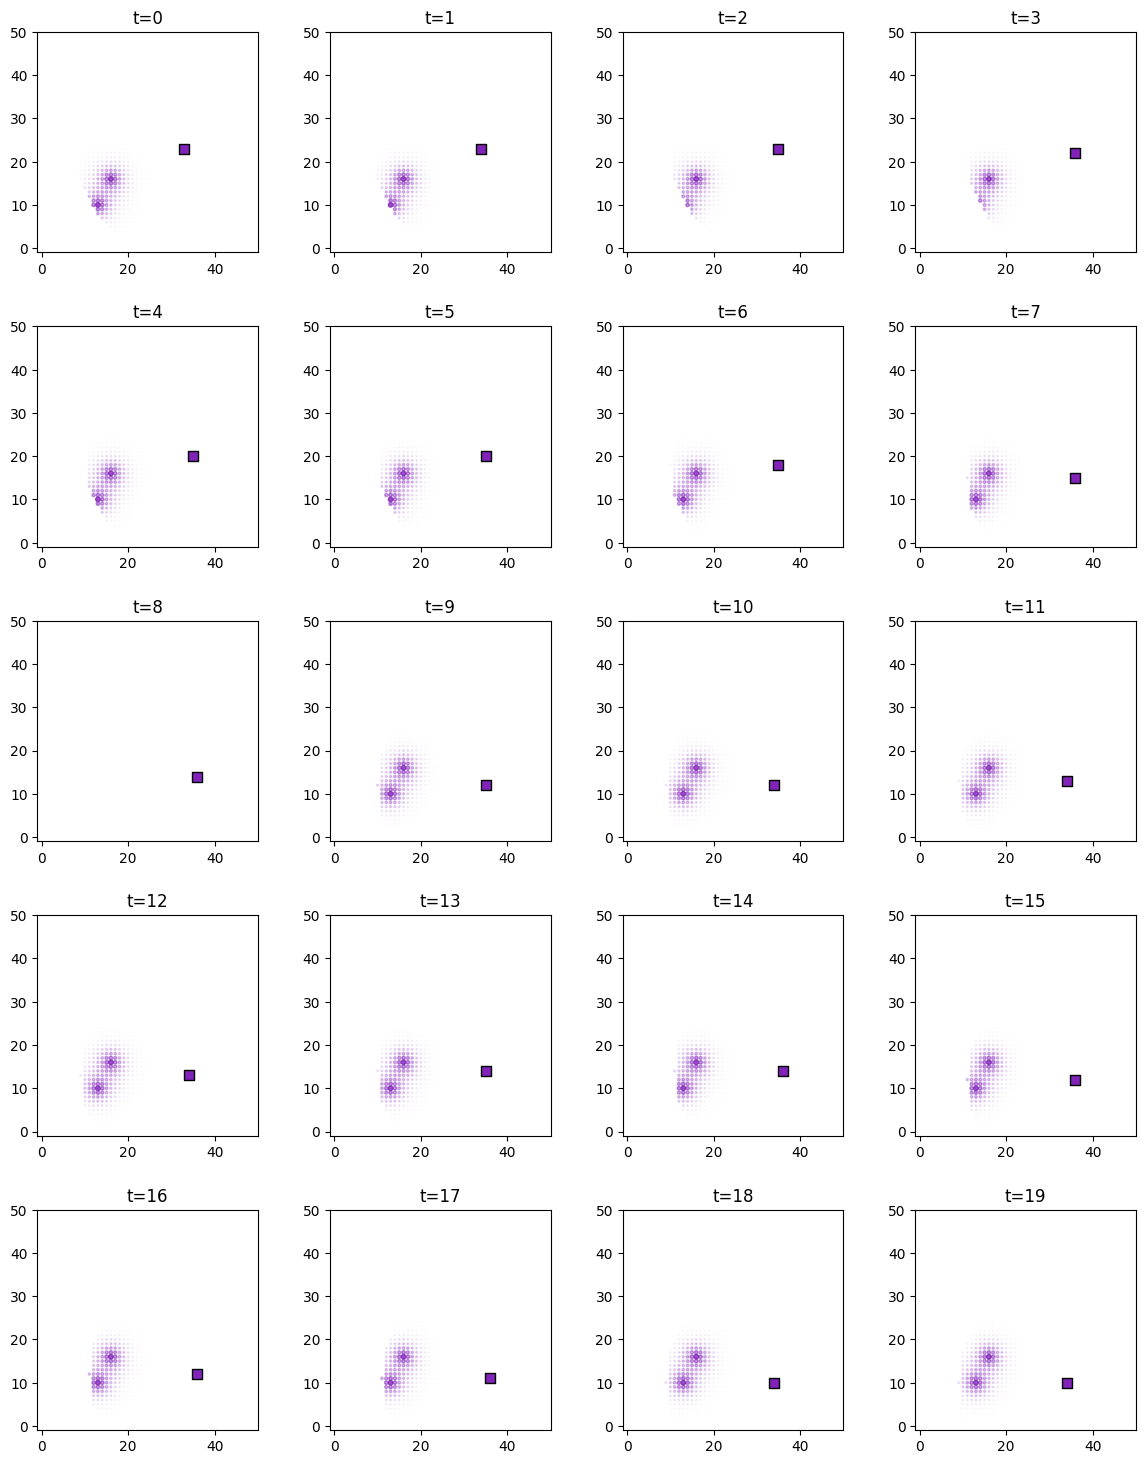

In [11]:
plot_predictor(
    foragers_object.foragers,
    ppr,
    "pred",
    [1],
    range(num_frames),
    grid_size,
    size_multiplier=10,
    random_state=99,
)

In [13]:
# load data
fish_data = pd.read_csv("4wpf_test.csv")
gridMin = 0
gridMax = 300
grid_size = 50
fps = 121

# scaling and subsampling
fishDF_scaled = rescale_to_grid(
    fish_data, size=grid_size, gridMin=gridMin, gridMax=gridMax
)
fishDF_scaled_subsampled = subsample_frames_constant_frame_rate(
    fishDF_scaled, frame_spacing=60, fps=fps
)

# create a test foragers object with 20 frames
num_frames = 20
foragers_object = dataObject(
    fishDF_scaled_subsampled.loc[fishDF_scaled_subsampled["time"] < 20],
    grid_size=grid_size,
)

# generate local windows and add to object
local_windows_kwargs = {
    "window_size": grid_size / 2,
    "sampling_fraction": 1,
    "skip_incomplete_frames": True,
}
foragers_object.local_windows_kwargs = local_windows_kwargs
local_windows = generate_local_windows(foragers_object)
foragers_object.local_windows = local_windows

foragers_object.rewards = rewards

predictor_kwargs = {
    "pred": {
        "decay_function": _exponential_decay,
        "decay_factor": 0.5,
    }
}


foragers_object.predictor_kwargs = predictor_kwargs

proximity = generate_food_predictor(foragers_object, predictor)


ani = animate_predictors(
    foragers_object.foragersDF,
    proximity,
    predictorID="pred",
    forager_index=[0, 3],
    grid_size=grid_size,
    random_state=10,
    size_multiplier=10,
)
HTML(ani.to_jshtml())

original_frames: 18739
original_shape: (74956, 5)
resulting_frames: 313
resulting_shape: (1252, 5)
new frame-rate =  2.02


/home/rafal/s78projects/collaborative-intelligence/collab2/foraging/toolkit/utils.py:36: UserWarning:  Nan values in data.
                Specify handling of missing data using `skip_incomplete_frames` argument to `generate_all_predictors`
  warnings.warn(


TypeError: generate_food_predictor() missing 1 required positional argument: 'predictor_name'